In [1]:
#importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score,recall_score
import joblib

In [2]:
Ulcer = pd.read_excel(r"/content/Ulcer_Daily_Logs.xlsx") # loading the data

In [3]:
# Display the first five rows
Ulcer.head()

,Date,Age,Gender,TakeUlcerMed,MedTime,PainRating,Symptoms,Duration,SymptomChange,Meals,TriggerCauses,AteTriggers,SkippedMeal,AteLate,TookNSAID,StressLevel,CancerDiag,FamilyHistory,HpyloriUlcer,LogTimestamp
0,2025-05-25,21,Female,No,16:54:00,2,Nausea,<30 mins,10,Fried Egg;Water,Alcohol,No,No,No,No,8,No,Yes,Not sure,2025-06-20 09:30:26
1,2025-05-25,18,Male,Yes,23:20:00,4,Loss of appetite,>2 hrs,4,Rice and Beans,Stress,No,No,No,Yes,9,Yes,Not sure,Yes,2025-06-18 11:35:49
2,2025-05-25,19,Female,No,NaN,4,Loss of appetite;Nausea,>2 hrs,5,White Rice,Stress,No,Yes,Yes,No,5,No,No,No,2025-06-16 15:59:00
3,2025-05-25,18,Male,No,04:44:00,2,Heartburn,30 mins–2 hrs,3,Juice,Alcohol,Yes,No,No,Yes,3,No,No,Yes,2025-06-21 15:36:15
4,2025-05-26,26,Male,Yes,10:31:00,3,Heartburn,<30 mins,4,Rice and Beans,Alcohol,No,Yes,Yes,Yes,0,No,Not sure,Not sure,2025-06-02 01:29:33


In [4]:
# Count and display the frequency of each unique value in the Meals column
Ulcer["Meals"].value_counts()

,count
Meals,
Fried Egg;Water,19
Rice and Beans,17
Juice,15
Spaghetti,14
White Rice,1
Jollof Rice;Fried Chicken,1
Fried Rice;Jollof Rice;Beef;Boiled Egg;Beans;Fried Chicken,1
White Rice;Beef;Cow Skin (Ponmo),1
Boiled Yam;Fried Egg,1


In [5]:
# Count and display the frequency of each unique value in the Symptoms column

Ulcer["Symptoms"].value_counts()

,count
Symptoms,
Loss of appetite,15
Persistent fatigue,14
Heartburn;Acid reflux,11
Persistent fatigue;Nausea,11
Dark or tarry stools,11
Heartburn,10
Nausea,10
Acid reflux,7
Acid reflux;Heartburn,3


In [6]:
# Check for missing values in each column and display the total count per column

Ulcer.isnull().sum()

,0
Date,0
Age,0
Gender,0
TakeUlcerMed,0
MedTime,8
PainRating,0
Symptoms,2
Duration,0
SymptomChange,0
Meals,25


In [7]:
# Count and display the frequency of each unique value in the MedTime column

Ulcer["MedTime"].value_counts()

,count
MedTime,
11:32:00,2
03:50:00,2
04:44:00,1
10:31:00,1
16:38:00,1
...,...
02:20:00,1
00:36:00,1
09:52:00,1


In [8]:
Ulcer["TakeUlcerMed"].value_counts()

,count
TakeUlcerMed,
No,51
Yes,49


In [9]:
# Fixing logical mismatch
Ulcer.loc[Ulcer['TakeUlcerMed'] == 'No', 'MedTime'] = 'Not Taken'

In [10]:
Ulcer['Meals'].fillna('No Meal', inplace=True) #filling missing values

In [11]:
mode_time = Ulcer[Ulcer['TakeUlcerMed'] == 'Yes']['MedTime'].mode()[0]  # most frequent valid time

In [12]:
Ulcer.isnull().sum() # checking for null values

,0
Date,0
Age,0
Gender,0
TakeUlcerMed,0
MedTime,0
PainRating,0
Symptoms,2
Duration,0
SymptomChange,0
Meals,0


In [13]:

#filling the missing value in the symptom variable
Ulcer['Symptoms'].fillna('No Symptom', inplace=True)


**Feature Engineering**

In [14]:

def classify_med_time(value):
    # Normalize string
    if isinstance(value, str):
        value = value.strip().lower()
        if value == 'not taken':
            return 'Not Taken'

    try:
        hour = int(str(value).split(':')[0])
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour <= 21:
            return 'Evening'
        else:
            return 'Night'
    except:
        return 'Unknown'


In [15]:
Ulcer['MedTimePeriod'] = Ulcer['MedTime'].apply(classify_med_time)


In [16]:
Ulcer.head()

,Date,Age,Gender,TakeUlcerMed,MedTime,PainRating,Symptoms,Duration,SymptomChange,Meals,...,AteTriggers,SkippedMeal,AteLate,TookNSAID,StressLevel,CancerDiag,FamilyHistory,HpyloriUlcer,LogTimestamp,MedTimePeriod
0,2025-05-25,21,Female,No,Not Taken,2,Nausea,<30 mins,10,Fried Egg;Water,...,No,No,No,No,8,No,Yes,Not sure,2025-06-20 09:30:26,Not Taken
1,2025-05-25,18,Male,Yes,23:20:00,4,Loss of appetite,>2 hrs,4,Rice and Beans,...,No,No,No,Yes,9,Yes,Not sure,Yes,2025-06-18 11:35:49,Night
2,2025-05-25,19,Female,No,Not Taken,4,Loss of appetite;Nausea,>2 hrs,5,White Rice,...,No,Yes,Yes,No,5,No,No,No,2025-06-16 15:59:00,Not Taken
3,2025-05-25,18,Male,No,Not Taken,2,Heartburn,30 mins–2 hrs,3,Juice,...,Yes,No,No,Yes,3,No,No,Yes,2025-06-21 15:36:15,Not Taken
4,2025-05-26,26,Male,Yes,10:31:00,3,Heartburn,<30 mins,4,Rice and Beans,...,No,Yes,Yes,Yes,0,No,Not sure,Not sure,2025-06-02 01:29:33,Morning


In [17]:
Ulcer['TriggerCauses'].value_counts()

,count
TriggerCauses,
Unknown,25
Stress,20
Spicy food,18
Alcohol,16
Late meals,13
Spicy foods,3
Spicy foods;Ate late,2
Skipped a meal,2
Spicy foods;Ate late;Ate under stress,1


In [18]:
Ulcer["MedTimePeriod"].value_counts()

,count
MedTimePeriod,
Not Taken,51
Night,14
Morning,14
Evening,13
Afternoon,8


In [19]:
def clean_multivalue_column(cell):
    import ast
    try:
        # Try converting from a real Python-style list string
        if isinstance(cell, str) and cell.startswith("["):
            return ast.literal_eval(cell)
        # Otherwise, assume it's a delimited string (e.g. "Rice;Beans")
        elif isinstance(cell, str):
            return [item.strip() for item in cell.replace(';', ',').split(',')]
        elif isinstance(cell, list):
            return cell
        else:
            return []
    except:
        return []


In [20]:
Ulcer['Meals'] = Ulcer['Meals'].apply(clean_multivalue_column)
Ulcer['Symptoms'] = Ulcer['Symptoms'].apply(clean_multivalue_column)
Ulcer['TriggerCauses'] = Ulcer['TriggerCauses'].apply(clean_multivalue_column)


In [21]:
# Import MultiLabelBinarizer to convert multiple labels in a list-like column into a binary (one-hot encoded) format
from sklearn.preprocessing import MultiLabelBinarizer


In [22]:
# Meal
mlb_meal = MultiLabelBinarizer()
meal_encoded = pd.DataFrame(mlb_meal.fit_transform(Ulcer['Meals']), columns=[f"meal_{c}" for c in mlb_meal.classes_])

# Symptom
mlb_symptom = MultiLabelBinarizer()
symptom_encoded = pd.DataFrame(mlb_symptom.fit_transform(Ulcer['Symptoms']), columns=[f"symptom_{c}" for c in mlb_symptom.classes_])

# TriggerCause
mlb_trigger = MultiLabelBinarizer()
trigger_encoded = pd.DataFrame(mlb_trigger.fit_transform(Ulcer['TriggerCauses']), columns=[f"trigger_{c}" for c in mlb_trigger.classes_])


In [23]:
joblib.dump(mlb_meal, 'mlb_meals.pkl')
joblib.dump(mlb_symptom, 'mlb_symptoms.pkl')
joblib.dump(mlb_trigger, 'mlb_triggers.pkl')

['mlb_triggers.pkl']

In [24]:
# Drop the original multi-label columns and combine the encoded ones
Ulcer = pd.concat([Ulcer.drop(columns=['Meals', 'Symptoms', 'TriggerCauses']),
                meal_encoded, symptom_encoded, trigger_encoded], axis=1)


In [25]:
Ulcer.head()

,Date,Age,Gender,TakeUlcerMed,MedTime,PainRating,Duration,SymptomChange,AteTriggers,SkippedMeal,...,symptom_Persistent fatigue,trigger_Alcohol,trigger_Ate late,trigger_Ate under stress,trigger_Late meals,trigger_Skipped a meal,trigger_Spicy food,trigger_Spicy foods,trigger_Stress,trigger_Unknown
0,2025-05-25,21,Female,No,Not Taken,2,<30 mins,10,No,No,...,0,1,0,0,0,0,0,0,0,0
1,2025-05-25,18,Male,Yes,23:20:00,4,>2 hrs,4,No,No,...,0,0,0,0,0,0,0,0,1,0
2,2025-05-25,19,Female,No,Not Taken,4,>2 hrs,5,No,Yes,...,0,0,0,0,0,0,0,0,1,0
3,2025-05-25,18,Male,No,Not Taken,2,30 mins–2 hrs,3,Yes,No,...,0,1,0,0,0,0,0,0,0,0
4,2025-05-26,26,Male,Yes,10:31:00,3,<30 mins,4,No,Yes,...,0,1,0,0,0,0,0,0,0,0


In [26]:
Ulcer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          100 non-null    datetime64[ns]
 1   Age                           100 non-null    int64         
 2   Gender                        100 non-null    object        
 3   TakeUlcerMed                  100 non-null    object        
 4   MedTime                       100 non-null    object        
 5   PainRating                    100 non-null    int64         
 6   Duration                      100 non-null    object        
 7   SymptomChange                 100 non-null    int64         
 8   AteTriggers                   100 non-null    object        
 9   SkippedMeal                   100 non-null    object        
 10  AteLate                       100 non-null    object        
 11  TookNSAID                     100

In [27]:
Ulcer['PainType'] = Ulcer['PainRating'].apply(lambda x: 'Safe' if x < 3 else 'Trigger')


In [28]:
binary_cols = ['TakeUlcerMed', 'AteTriggers', 'SkippedMeal',
               'AteLate', 'TookNSAID', 'CancerDiag']

# Convert 'Yes' to 1, 'No' to 0
for col in binary_cols:
    Ulcer[col] = Ulcer[col].map({'Yes': 1, 'No': 0})


In [29]:
Ulcer['FamilyHistory'].value_counts()

,count
FamilyHistory,
No,35
Not sure,33
Yes,32


In [30]:
Ulcer['HpyloriUlcer'].value_counts()

,count
HpyloriUlcer,
Yes,39
Not sure,32
No,29


In [31]:
# Convert the 'Gender' column to binary format (Male = 1, Female = 0)
Ulcer['Gender'] = Ulcer['Gender'].map({'Male': 1, 'Female': 0})


In [32]:
# Map the 'PainType' column to binary values and store it in a new column called 'TriggerLabel'

Ulcer['TriggerLabel'] = Ulcer['PainType'].map({'Safe': 0, 'Trigger': 1})


In [33]:
# Encode multiple categorical columns using LabelEncoder
# store each encoder in a dictionary
from sklearn.preprocessing import LabelEncoder
multi_cols = ['Duration', 'MedTimePeriod', 'HpyloriUlcer', 'FamilyHistory']
label_encoders = {}

for col in multi_cols:
    le = LabelEncoder()
    Ulcer[col] = le.fit_transform(Ulcer[col])
    label_encoders[col] = le
    joblib.dump(le, f'label_encoder_{col}.pkl')

In [34]:
Ulcer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          100 non-null    datetime64[ns]
 1   Age                           100 non-null    int64         
 2   Gender                        100 non-null    int64         
 3   TakeUlcerMed                  100 non-null    int64         
 4   MedTime                       100 non-null    object        
 5   PainRating                    100 non-null    int64         
 6   Duration                      100 non-null    int64         
 7   SymptomChange                 100 non-null    int64         
 8   AteTriggers                   100 non-null    int64         
 9   SkippedMeal                   100 non-null    int64         
 10  AteLate                       100 non-null    int64         
 11  TookNSAID                     100

In [35]:
Ulcer.head()

,Date,Age,Gender,TakeUlcerMed,MedTime,PainRating,Duration,SymptomChange,AteTriggers,SkippedMeal,...,trigger_Ate late,trigger_Ate under stress,trigger_Late meals,trigger_Skipped a meal,trigger_Spicy food,trigger_Spicy foods,trigger_Stress,trigger_Unknown,PainType,TriggerLabel
0,2025-05-25,21,0,0,Not Taken,2,1,10,0,0,...,0,0,0,0,0,0,0,0,Safe,0
1,2025-05-25,18,1,1,23:20:00,4,2,4,0,0,...,0,0,0,0,0,0,1,0,Trigger,1
2,2025-05-25,19,0,0,Not Taken,4,2,5,0,1,...,0,0,0,0,0,0,1,0,Trigger,1
3,2025-05-25,18,1,0,Not Taken,2,0,3,1,0,...,0,0,0,0,0,0,0,0,Safe,0
4,2025-05-26,26,1,1,10:31:00,3,1,4,0,1,...,0,0,0,0,0,0,0,0,Trigger,1


In [36]:
# Define features and target for model training
X = Ulcer.drop(['Date','MedTime', 'PainType', 'TriggerLabel','LogTimestamp'], axis=1)
y = Ulcer['TriggerLabel']


In [37]:
# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
#  Random Forest: Hyperparameter Tuning
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [40]:
# XGBoost: Hyperparameter Tuning
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)



Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [41]:
# Best Estimators
rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

In [42]:
#Evaluation on Test Set
for name, model in {'Random Forest': rf_best, 'XGBoost': xgb_best}.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print("Best Parameters:", model.get_params())
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Evaluation:
Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 1.0
F1 Score: 1.0
Recall: 1.0
Confusion Matrix:
 [[ 9  0]
 [ 0 11]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


XGBoost Evaluation:
Best Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'call

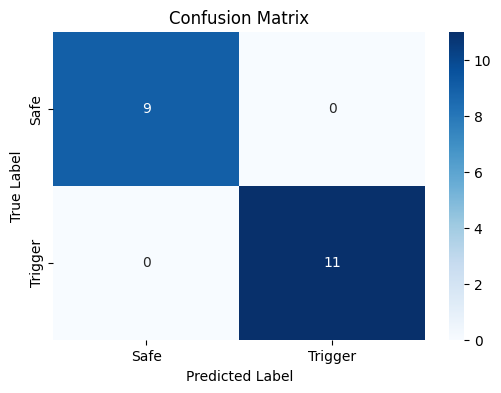

In [43]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Trigger'], yticklabels=['Safe', 'Trigger'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
import joblib

# Save model
joblib.dump(rf_model, 'ulcer_meal_model.pkl')


['ulcer_meal_model.pkl']

In [45]:
#load the model
rf_model = joblib.load('ulcer_meal_model.pkl')


In [46]:
# New user input (from app)
user_input = {
    'Age': 21,
    'Gender': 'Female',
    'TakeUlcerMed': 'Yes',
    'Symptoms': ['Heartburn'],
    'Duration':'30 mins–2 hrs' ,
    'SymptomChange': 4,
    'Meals': ['Rice and Beans'],
    'TriggerCauses': ['Spicy food'],
    'AteTriggers': 'Yes',
    'SkippedMeal': 'No',
    'AteLate': 'No',
    'TookNSAID': 'No',
    'StressLevel': 3,
    'CancerDiag': 'No',
    'FamilyHistory': 'Yes',
    'HpyloriUlcer': 'No',
    'MedTimePeriod': 'Morning'
}


In [47]:
# Load label encoders
label_encoders = {
    'Duration': joblib.load('label_encoder_Duration.pkl'),
    'MedTimePeriod': joblib.load('label_encoder_MedTimePeriod.pkl'),
    'HpyloriUlcer': joblib.load('label_encoder_HpyloriUlcer.pkl'),
    'FamilyHistory': joblib.load('label_encoder_FamilyHistory.pkl'),
}

In [48]:
print(label_encoders['Duration'].classes_)

['30 mins–2 hrs' '<30 mins' '>2 hrs']


In [49]:
# Load MultiLabelBinarizers
mlb_meals = joblib.load('mlb_meals.pkl')
mlb_symptoms = joblib.load('mlb_symptoms.pkl')
mlb_triggers = joblib.load('mlb_triggers.pkl')


In [50]:
joblib.dump(X.columns.tolist(), 'X_columns.pkl')

['X_columns.pkl']

In [51]:
X_columns = joblib.load('X_columns.pkl')

In [52]:
binary_map = {'Yes': 1, 'No': 0}


In [53]:
encoded = {}

# Binary & categorical values
encoded['Age'] = user_input['Age']
encoded['Gender'] = 1 if user_input['Gender'].lower() == 'female' else 0
encoded['TakeUlcerMed'] = binary_map[user_input['TakeUlcerMed']]
encoded['AteTriggers'] = binary_map[user_input['AteTriggers']]
encoded['SkippedMeal'] = binary_map[user_input['SkippedMeal']]
encoded['AteLate'] = binary_map[user_input['AteLate']]
encoded['TookNSAID'] = binary_map[user_input['TookNSAID']]
encoded['CancerDiag'] = binary_map[user_input['CancerDiag']]
encoded['StressLevel'] = user_input['StressLevel']
encoded['SymptomChange'] = user_input['SymptomChange']

# Label Encoded features
for col in ['Duration', 'MedTimePeriod', 'HpyloriUlcer', 'FamilyHistory']:
    encoded[col] = label_encoders[col].transform([user_input[col]])[0]

# Multi-label binarized features
symptoms_bin = mlb_symptoms.transform([user_input['Symptoms']])
meals_bin = mlb_meals.transform([user_input['Meals']])
triggers_bin = mlb_triggers.transform([user_input['TriggerCauses']])


In [54]:
# Merge all into a dictionary
flat_input = {
    **encoded,
    **dict(zip(mlb_symptoms.classes_, symptoms_bin[0])),
    **dict(zip(mlb_meals.classes_, meals_bin[0])),
    **dict(zip(mlb_triggers.classes_, triggers_bin[0]))
}

# Ensure correct order
final_input_array = np.array([flat_input.get(col, 0) for col in X_columns]).reshape(1, -1)


In [55]:
prediction = model.predict(final_input_array)[0]


In [56]:
#  Recommend Meals Based on Prediction
if prediction == 0:  # 0 = Safe
    print("✅ You are not likely to have ulcer triggers today. Here are some safe meals to enjoy:")
    safe_meals = [
        'Pap and Akara',
        'Boiled Yam with Garden Egg Sauce',
        'Unripe Plantain Porridge',
        'Oats with Milk',
        'Eba with Okro (non-spicy)',
        'Rice and Beans (lightly seasoned)',
        'Soft Fufu with Mild Vegetable Soup',
        'Boiled Sweet Potatoes and Greens',
        'Plain Custard with Milk'
    ]
    for meal in safe_meals:
        print("•", meal)

else:
    print("⚠️ You may be at risk of pain triggers. Please avoid spicy, fried, or acidic foods.")
    print("Instead, try these soothing, stomach-friendly meals:")
    soothing_meals = [
        'Pap and Moi Moi',
        'Boiled Potatoes with Light Vegetable Sauce',
        'Plain Custard',
        'Rice with White Soup',
        'Soft Plantain Porridge',
        'Boiled Green Bananas with Soft Sauce',
        'Light Yam Porridge',
        'Oats with Honey (no sugar)',
        'Rice Porridge (congee style)'
    ]
    for meal in soothing_meals:
        print("•", meal)


✅ You are not likely to have ulcer triggers today. Here are some safe meals to enjoy:
• Pap and Akara
• Boiled Yam with Garden Egg Sauce
• Unripe Plantain Porridge
• Oats with Milk
• Eba with Okro (non-spicy)
• Rice and Beans (lightly seasoned)
• Soft Fufu with Mild Vegetable Soup
• Boiled Sweet Potatoes and Greens
• Plain Custard with Milk
